# Mock AlphaGo Zero (2) - Policy and Value Network
In this notebook, we will build the model of AlphaGo's Policy Network, which is a dCNN.

In [1]:
import os, numpy as np
from caffe2.python import core, model_helper, workspace, brew, utils
from caffe2.proto import caffe2_pb2

%matplotlib inline
from matplotlib import pyplot

NUM_RES_BLOCKS = 4 # [19(alphago zero),39] How many Residual Blocks will be used in the model
FILTERS = 256 # 128/192/256(alphago zero)/384 How many K will be used in the model
BASE_LR = -0.1 # (-0.1,0) The base Learning Rate, alphago zero uses -0.1 and times 0.1 every 200K iters

if workspace.has_gpu_support:
    device_opts = core.DeviceOption(caffe2_pb2.CUDA, workspace.GetDefaultGPUID())
    print('Running in GPU mode on default device {}'.format(workspace.GetDefaultGPUID()))
else :
    device_opts = core.DeviceOption(caffe2_pb2.CPU, 0)
    print('Running in CPU mode')

TRAIN_BATCHES = 64 # how many samples will be trained within one mini-batch, depends on your hardware
PRE_TRAINED_ITERS = 0 # [0, infinity) how many batches the model has been trained before
SKIP_TRAINED_DATA = 0 # [0, infinity) if this is a resumed training, how many input data will be skipped
TRAIN_ITERS = 1000 # [0, infinity) how many batches the model will be trained
TEST_BATCHES = 100 # how many samples will be tested within one mini-batch
TEST_ITERS = 10000 # how many batches the model will be tested

ROOT_FOLDER = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_data','zero','param') # folder stores the loss/accuracy log
DATA_FOLDER = os.path.join(os.path.expanduser('~'), 'python', 'tutorial_data','zero')
TRAIN_DATA = os.path.join(DATA_FOLDER,'tr_data') # db folder stores the preprocessed games
TEST_DATA = os.path.join(DATA_FOLDER,'test_data') # db folder stores the preprocessed games

# if this is a resumed training, where to load the init_param from
LOAD_FOLDER = os.path.join(ROOT_FOLDER, "res={}-k={}-iter={}".format(NUM_RES_BLOCKS,FILTERS,PRE_TRAINED_ITERS))

# if the model will be saved for future resume training, where to store it
SAVE_FOLDER = os.path.join(ROOT_FOLDER, "res={}-k={}-iter={}".format(NUM_RES_BLOCKS,FILTERS,PRE_TRAINED_ITERS+TRAIN_ITERS))

workspace.ResetWorkspace(ROOT_FOLDER)

print('Training model from {} to {} iterations'.format(PRE_TRAINED_ITERS,PRE_TRAINED_ITERS+TRAIN_ITERS))

Running in GPU mode on default device 0
Training model from 0 to 1000 iterations


## AlphaGo Neural Network Architecture


### Data Input
>The input to the neural network is a 19 × 19 × 17 image stack
comprising 17 binary feature planes. 8 feature planes $X_t$ consist of binary values indicating the
presence of the current player’s stones ($X_t^i = 1$ if intersection $i$ contains a stone of the player’s
colour at time-step $t$; $0$ if the intersection is empty, contains an opponent stone, or if $t < 0$). A
further 8 feature planes, $Y_t$ , represent the corresponding features for the opponent’s stones. The
final feature plane, $C$, represents the colour to play, and has a constant value of either 1 if black
is to play or 0 if white is to play. These planes are concatenated together to give input features
$s_t = [X_t , Y_t , X_{t−1} , Y_{t−1} , ..., X_{t−7} , Y_{t−7} , C]$.

In [2]:
from modelingZero import AddInput

### DCNN
>The input features $S_t$ are processed by a residual tower that consists of a single convolutional block followed by either 19 or 39 residual blocks 4. The convolutional block applies the following modules:
1. A convolution of 256 filters of kernel size 3 x 3 with stride 1
2. Batch normalisation 18
3. A rectifier non-linearity

>Each residual block applies the following modules sequentially to its input:
1. A convolution of 256 filters of kernel size 3 x 3 with stride 1
2. Batch normalisation
3. A rectifier non-linearity
4. A convolution of 256 filters of kernel size 3 x 3 with stride 1
5. Batch normalisation
6. A skip connection that adds the input to the block
7. A rectifier non-linearity

>The output of the residual tower is passed into two separate “heads” for computing the policy and value respectively. The policy head applies the following modules:
1. A convolution of 2 filters of kernel size 1 x 1 with stride 1
2. Batch normalisation
3. A rectifier non-linearity
4. A fully connected linear layer that outputs a vector of size 192 + 1 = 362 corresponding to logit probabilities for all intersections and the pass move

>The value head applies the following modules:
1. A convolution of 1 filter of kernel size 1 x 1 with stride 1
2. Batch normalisation
3. A rectifier non-linearity
4. A fully connected linear layer to a hidden layer of size 256
5. A rectifier non-linearity
6. A fully connected linear layer to a scalar
7. A tanh non-linearity outputting a scalar in the range `[-1; 1]`

In [3]:
from modelingZero import AddResNetModel

### Accuracy
Please note predict is 4 dimensional tensor in shape of N x 1 x 19 x 19, and label is 2 dimensional tensor in shape of N x 1.

In [4]:
from modelingZero import AddAccuracy

### Training Operator (Backward Propagation)

>A game terminates at step $T$ when both players pass, when the search value drops below a 
resignation threshold (`10%`), or when the game exceeds a maximum length (`722 steps`); 
the game is then scored to give a final reward of $r_T\in\{-1,+1\}$ (see
Methods for details). The data for each time-step $t$ is stored as $(s_t, \pi_t, z_t)$ 
where $z_t = \pm r_T$ is the game winner from the perspective of the current player at step $t$.
In parallel (Figure 1b), new network parameters $\theta_i$ are trained from data $(s,\pi,z)$
sampled uniformly among all time-steps of the last iteration(s) of self-play. The neural 
network $(p,v) = f_{\theta _i}(s)$ is adjusted to minimise the error between the predicted 
value $v$ and the self-play winner $z$, and to maximise the similarity of the neural network 
move probabilities $p$ to the search probabilities $\pi$. Specifically, the parameters $\theta$
are adjusted by gradient descent on a loss function $l$ that sums over mean-squared error and
cross-entropy losses respectively,

>>$(p,v) = f_\theta(s), l = (z - v)^2 \pi^T \log p + c|| \theta ||^2$



In [5]:
from modelingZero import AddTrainingOperators

### Trace the training progress
Print 'accuracy' and 'loss' to file and we can monitor them elsewhere.

In [6]:
from modelingZero import AddBookkeepingOperators

## Build the actual network

In [7]:
arg_scope = {"order": "NCHW"}

### Train Net

In [8]:
# Skip model only has DBInput to waste the input
skip_model = model_helper.ModelHelper(name="skip_model", arg_scope=arg_scope, init_params=True)
_d, _l, _r = AddInput(
    skip_model, batch_size=TRAIN_BATCHES,
    db=TRAIN_DATA,
    db_type='leveldb')
# Initialize params and create network
workspace.RunNetOnce(skip_model.param_init_net)
workspace.CreateNet(skip_model.net, overwrite=True)

True

In [30]:
# Train Net: DBInput ==> Predict Net ==> Loss ==> Backward Propergation
with core.DeviceScope(device_opts):
    train_model = model_helper.ModelHelper(name="policy_train", arg_scope=arg_scope, init_params=True)
    data, label, reward = AddInput(
        train_model, batch_size=TRAIN_BATCHES,
        db=TRAIN_DATA,
        db_type='leveldb')
    predict, value = AddResNetModel(train_model, data, num_blocks=NUM_RES_BLOCKS, filters=FILTERS, dim_in=17)
    AddTrainingOperators(train_model, predict, label, value, reward, base_lr=BASE_LR)
    AddBookkeepingOperators(train_model)
# Initialize params and create network
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)

True

### Test Net

In [10]:
# Test Net: DBInput ==> Predict Net ==> Accuracy
with core.DeviceScope(device_opts):
    test_model = model_helper.ModelHelper(name="policy_test", arg_scope=arg_scope, init_params=False)
    data, label, reward = AddInput(
        test_model, batch_size=TEST_BATCHES,
        db=TEST_DATA,
        db_type='leveldb')
    predict, value = AddResNetModel(test_model, data, num_blocks=NUM_RES_BLOCKS, filters=FILTERS, dim_in=17)
    AddAccuracy(test_model, predict, label)
# Initialize params and create network
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

True

### Deploy Net

In [11]:
# Train Net: Blob('data') ==> Predict Net ==> Blob('predict')
with core.DeviceScope(device_opts):
    deploy_model = model_helper.ModelHelper(name="policy_deploy", arg_scope=arg_scope, init_params=False)
    AddResNetModel(deploy_model, 'data', num_blocks=NUM_RES_BLOCKS, filters=FILTERS, dim_in=17)
# Initialize params and create network
workspace.RunNetOnce(deploy_model.param_init_net)
workspace.CreateNet(deploy_model.net, overwrite=True)

True

## Run the training and testing
### resume from last training
    Training a multi-level CNN takes quite a long time. To pause-and-resume the training, set the PRE_TRAINED_ITERS so the program will start from where last time it was.

In [12]:
import caffe2.python.predictor.predictor_exporter as pe

# construct the model to be exported
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params], 
    inputs=["data"],
    outputs=["predict"],
)

if PRE_TRAINED_ITERS > 0:
    #load_net(LOAD_INIT_NET, LOAD_PREDICT_NET)
    # load the predict net
    with core.DeviceScope(device_opts):
        deploy_model.net = pe.prepare_prediction_net(os.path.join(LOAD_FOLDER, "policy_model.minidb"), "minidb")
    print('Params loaded from {}'.format(LOAD_FOLDER))

### Train the model

In [33]:
#%%capture output # Jupyter magic command to capture the output

if TRAIN_ITERS > 0:
    # skip the data which should not be trained again
    for i in range(SKIP_TRAINED_DATA):
        workspace.RunNet(skip_model.net)
    
    # set the number of iterations and track the accuracy & loss
    accuracy = np.zeros(TRAIN_ITERS)
    loss = np.zeros(TRAIN_ITERS)
    loss1 = np.zeros(TRAIN_ITERS)
    loss2 = np.zeros(TRAIN_ITERS)
    # Now, run the network 
    for i in range(TRAIN_ITERS):
        workspace.RunNet(train_model.net)
        accuracy[i] = workspace.FetchBlob('accuracy')
        loss[i] = workspace.FetchBlob('loss')
        loss1[i] = workspace.FetchBlob('loss1')
        loss2[i] = workspace.FetchBlob('loss2')
        # checkpoint every 10000 iterations
        if i > 0 and i % 10000 == 0:
            if not os.path.exists(SAVE_FOLDER):
                os.makedirs(SAVE_FOLDER)
            pe.save_to_db("minidb", os.path.join(SAVE_FOLDER, "policy_model_checkpoint_{}.minidb".format(PRE_TRAINED_ITERS+i)), pe_meta)
            print('Checkpoint {} saved to {}'.format(PRE_TRAINED_ITERS+i,SAVE_FOLDER))


KeyboardInterrupt: 

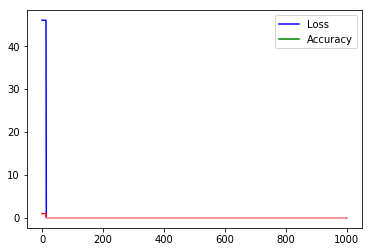

In [34]:
# After the execution is done, plot the values.
pyplot.plot(loss1, 'b')
pyplot.plot(loss2, 'g')
pyplot.plot(accuracy, 'r')
pyplot.plot(loss, 'pink')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

### Test the model

In [ ]:
test_accuracy = np.zeros(TEST_ITERS)
for i in range(TEST_ITERS):
    workspace.RunNet(test_model.net)
    test_accuracy[i] = workspace.FetchBlob('accuracy')
# After the execution is done, let's plot the values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Acuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

### Save the work for future use

In [ ]:
if TRAIN_ITERS > 0:
    if not os.path.exists(SAVE_FOLDER):
        os.makedirs(SAVE_FOLDER)
    # save the model to a file. Use minidb as the file format
    pe.save_to_db("minidb", os.path.join(SAVE_FOLDER, "policy_model.minidb"), pe_meta)
    print('Params saved to {}'.format(SAVE_FOLDER))

In [31]:
workspace.RunNet(train_model.net)

True

In [35]:
workspace.FetchBlob('conv1')

array([[[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ..., 
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ..., 
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ..., 
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        ..., 

In [ ]:
workspace.FetchBlob('policy').shape